In [1]:
import torch
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, Tensor
from zeta.nn import SSM
from einops.layers.torch import Reduce
import os

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import pytorch_lightning as pl 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

%load_ext tensorboard
pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/home/ubuntu/miniconda3/envs/visionmamba/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-30 18:42:54,715 - lightning_fabric.utilities.seed - INFO - Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
CHECKPOINT_PATH = "./saved_models"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


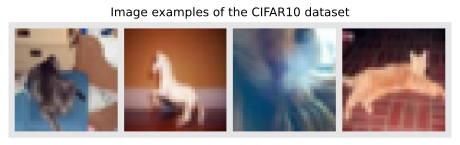

In [3]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root='/home/ubuntu/VisionMamba/CIFAR10', train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root='/home/ubuntu/VisionMamba/CIFAR10', train=True, transform=test_transform, download=True)
#pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
#pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root='/home/ubuntu/VisionMamba/CIFAR10', train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [4]:
val_set[0][0].size()

torch.Size([3, 32, 32])

In [6]:
for i, (data, label) in enumerate(val_loader):
    print(data.min(), data.max())
    print(label)
    break

tensor(-1.9892) tensor(2.1268)
tensor([3, 7, 3, 3, 3, 5, 3, 0, 7, 5, 2, 0, 0, 7, 3, 3, 0, 5, 3, 0, 6, 4, 3, 7,
        0, 9, 4, 7, 8, 1, 2, 6, 2, 4, 5, 6, 3, 0, 9, 6, 0, 3, 8, 9, 0, 3, 1, 3,
        5, 6, 7, 2, 6, 3, 7, 0, 9, 1, 1, 6, 4, 7, 7, 6, 3, 6, 2, 3, 7, 5, 8, 1,
        1, 4, 9, 8, 2, 3, 3, 3, 8, 2, 8, 3, 2, 1, 6, 8, 8, 6, 9, 6, 1, 3, 4, 0,
        2, 5, 2, 7, 5, 4, 1, 4, 6, 3, 7, 9, 3, 5, 3, 0, 2, 0, 1, 4, 4, 0, 6, 7,
        8, 7, 6, 1, 9, 6, 4, 0])


In [5]:

# Pair
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


In [6]:

def output_head(dim: int, num_classes: int):
    """
    Creates a head for the output layer of a model.

    Args:
        dim (int): The input dimension of the head.
        num_classes (int): The number of output classes.

    Returns:
        nn.Sequential: The output head module.
    """
    return nn.Sequential(
        Reduce("b s d -> b d", "mean"),
        nn.LayerNorm(dim),
        nn.Linear(dim, num_classes),
    )



In [7]:

class VisionEncoderMambaBlock(nn.Module):
    """
    VisionMambaBlock is a module that implements the Mamba block from the paper
    Vision Mamba: Efficient Visual Representation Learning with Bidirectional
    State Space Model

    Args:
        dim (int): The input dimension of the input tensor.
        dt_rank (int): The rank of the state space model.
        dim_inner (int): The dimension of the inner layer of the
            multi-head attention.
        d_state (int): The dimension of the state space model.


    Example:
    >>> block = VisionMambaBlock(dim=256, heads=8, dt_rank=32,
            dim_inner=512, d_state=256)
    >>> x = torch.randn(1, 32, 256)
    >>> out = block(x)
    >>> out.shape
    torch.Size([1, 32, 256])
    """

    def __init__(
        self,
        dim: int,
        dt_rank: int,
        dim_inner: int,
        d_state: int,
    ):
        super().__init__()
        self.dim = dim
        self.dt_rank = dt_rank
        self.dim_inner = dim_inner
        self.d_state = d_state

        self.forward_conv1d = nn.Conv1d(
            in_channels=dim, out_channels=dim, kernel_size=1
        )
        self.backward_conv1d = nn.Conv1d(
            in_channels=dim, out_channels=dim, kernel_size=1
        )
        self.norm = nn.LayerNorm(dim)
        self.silu = nn.SiLU()
        self.ssm = SSM(dim, dt_rank, dim_inner, d_state)

        # Linear layer for z and x
        self.proj = nn.Linear(dim, dim)

        # Softplus
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor):
        b, s, d = x.shape

        # Skip connection
        skip = x

        # Normalization
        x = self.norm(x)

        # Split x into x1 and x2 with linears
        z1 = self.proj(x)
        x = self.proj(x)

        # forward con1d
        x1 = self.process_direction(
            x,
            self.forward_conv1d,
            self.ssm,
        )

        # backward conv1d
        x2 = self.process_direction(
            x,
            self.backward_conv1d,
            self.ssm,
        )

        # Activation
        z = self.silu(z1)

        # Matmul
        x1 *= z
        x2 *= z

        # Residual connection
        return x1 + x2 + skip

    def process_direction(
        self,
        x: Tensor,
        conv1d: nn.Conv1d,
        ssm: SSM,
    ):
        x = rearrange(x, "b s d -> b d s")
        x = self.softplus(conv1d(x))
        #print(f"Conv1d: {x}")
        x = rearrange(x, "b d s -> b s d")
        x = ssm(x)
        return x


In [8]:

class Vim(nn.Module):
    """
    Vision Mamba (Vim) model implementation.

    Args:
        dim (int): Dimension of the model.
        dt_rank (int, optional): Rank of the dynamic tensor. Defaults to 32.
        dim_inner (int, optional): Inner dimension of the model. Defaults to None.
        d_state (int, optional): State dimension of the model. Defaults to None.
        num_classes (int, optional): Number of output classes. Defaults to None.
        image_size (int, optional): Size of the input image. Defaults to 224.
        patch_size (int, optional): Size of the image patch. Defaults to 16.
        channels (int, optional): Number of image channels. Defaults to 3.
        dropout (float, optional): Dropout rate. Defaults to 0.1.
        depth (int, optional): Number of encoder layers. Defaults to 12.

    Attributes:
        dim (int): Dimension of the model.
        dt_rank (int): Rank of the dynamic tensor.
        dim_inner (int): Inner dimension of the model.
        d_state (int): State dimension of the model.
        num_classes (int): Number of output classes.
        image_size (int): Size of the input image.
        patch_size (int): Size of the image patch.
        channels (int): Number of image channels.
        dropout (float): Dropout rate.
        depth (int): Number of encoder layers.
        to_patch_embedding (nn.Sequential): Sequential module for patch embedding.
        dropout (nn.Dropout): Dropout module.
        cls_token (nn.Parameter): Class token parameter.
        to_latent (nn.Identity): Identity module for latent representation.
        layers (nn.ModuleList): List of encoder layers.
        output_head (output_head): Output head module.

    """

    def __init__(
        self,
        dim: int,
        dt_rank: int = 8,
        dim_inner: int = None,
        d_state: int = None,
        num_classes: int = None,
        image_size: int = 32,
        patch_size: int = 4,
        channels: int = 3,
        dropout: float = 0.1,
        depth: int = 12,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.dt_rank = dt_rank
        self.dim_inner = dim_inner
        self.d_state = d_state
        self.num_classes = num_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.channels = channels
        self.dropout = dropout
        self.depth = depth

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)",
                p1=patch_height,
                p2=patch_height,
            ),
            nn.Linear(patch_dim, dim),
        )
        
        self.pos_embeddings = nn.Parameter(torch.randn((1, 1, dim)))

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # Latent
        self.to_latent = nn.Identity()

        # encoder layers
        self.layers = nn.ModuleList()

        # Append the encoder layers
        for _ in range(depth):
            self.layers.append(
                VisionEncoderMambaBlock(
                    dim=dim,
                    dt_rank=dt_rank,
                    dim_inner=dim_inner,
                    d_state=d_state,
                    *args,
                    **kwargs,
                )
            )

        # Output head
        self.output_head = output_head(dim, num_classes)

    def forward(self, x: Tensor):
        # Patch embedding
        b, c, h, w = x.shape

        x = self.to_patch_embedding(x)
        #print(f"Patch embedding: {x.shape}")

        # Shape
        b, n, _ = x.shape

        # Cls tokens
        cls_tokens = repeat(self.cls_token, "() n d -> b n d", b=b)
        #print(f"Cls tokens: {cls_tokens.shape}")

        # Pos embeddings
        pos_embeddings = repeat(self.pos_embeddings, "() () d -> b n d", b=b, n=n)
        x += pos_embeddings
        #print(f"After adding Pos embeddings: {x.shape}")

        # Concatenate
        x = torch.cat((cls_tokens, x), dim=1)
        #print(f"Post token add: {x.shape}")

        # Dropout
        x = self.dropout(x)
        #print(x.shape)

        # Forward pass with the layers
        for layer in self.layers:
            x = layer(x)
            #print(f"Layer: {x.shape}")

        # Latent
        x = self.to_latent(x)

        # x = reduce(x, "b s d -> b d", "mean")

        # Output head with the cls tokens
        return self.output_head(x)

model = Vim(
    dim=32,  # Dimension of the transformer model
    dt_rank=8,  # Rank of the dynamic routing matrix
    dim_inner=32,  # Inner dimension of the transformer model
    d_state=32,  # Dimension of the state vector
    num_classes=10,  # Number of output classes
    image_size=32,  # Size of the input image
    patch_size=4,  # Size of each image patch
    channels=3,  # Number of input channels
    dropout=0.1,  # Dropout rate
    depth= 4,  # Depth of the transformer model
)


# Forward pass
x = torch.randn(
    1, 3, 32, 32
)  # Input tensor with shape (batch_size, channels, height, width)


out = model(x)  # Output tensor from the model


print(out.shape)  # Print the shape of the output tensor
print(out)  # Print the output tensor

In [9]:
class ViMamba(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = Vim(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [10]:
print(CHECKPOINT_PATH)

./saved_models


In [11]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViMamba"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = "/home/ubuntu/VisionMamba/vision_mamba/saved_models/ViMamba/lightning_logs/version_2/checkpoints/epoch=105-step=37206.ckpt1"
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViMamba.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
        trainer.fit(model, train_loader, val_loader)
        model = ViMamba.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    else:
        pl.seed_everything(42) # To be reproducable
        model = ViMamba(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViMamba.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [12]:
model, results = train_model(model_kwargs={
    'dim': 64,
    'dt_rank': 16,
    'dim_inner': 64,
    'd_state': 64,
    'num_classes': 10,
    'image_size': 32,
    'patch_size': 4,
    'channels': 3,
    'dropout': 0.1,
    'depth': 4}, lr=3e-4)

2024-05-27 19:27:31,547 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
2024-05-27 19:27:31,561 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-05-27 19:27:31,561 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-05-27 19:27:31,562 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs
2024-05-27 19:27:31,577 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2024-05-27 19:27:32,036 - pytorch_lightning.utilities.rank_zero - INFO - You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-05-27 19:27:32,044 - pytorch_lightning.accel

Epoch 199: 100%|██████████| 351/351 [01:13<00:00,  4.80it/s, v_num=7]      

2024-05-27 23:30:44,588 - pytorch_lightning.utilities.rank_zero - INFO - `Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 351/351 [01:13<00:00,  4.80it/s, v_num=7]


2024-05-27 23:30:45,367 - pytorch_lightning.accelerators.cuda - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s]


2024-05-27 23:30:53,867 - pytorch_lightning.accelerators.cuda - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 15.27it/s]


model = Vim(
    dim=32,  # Dimension of the transformer model
    dt_rank=8,  # Rank of the dynamic routing matrix
    dim_inner=32,  # Inner dimension of the transformer model
    d_state=32,  # Dimension of the state vector
    num_classes=10,  # Number of output classes
    image_size=32,  # Size of the input image
    patch_size=4,  # Size of each image patch
    channels=3,  # Number of input channels
    dropout=0.1,  # Dropout rate
    depth= 4,  # Depth of the transformer model
)


In [25]:
results

{'test': 0.6114000082015991, 'val': 0.6287999749183655}

def train(model, train_loader, val_loader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        train_loss = train_batch(model, train_loader)
        val_loss = test_batch(model, val_loader)

    def train_batch(model, train_loader):
        train_loss = 0
        model.train()
        for i, sample, anno in enumerate(train_loader):
            pred = model(sample)
            loss = compute_loss(pred, anno)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        return train_loss
            
            
            
